### **1. Importing Libraries**





In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.models import save_model
import pandas as pd
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline


### **2. Loading & Processing Data**





In [2]:
def data_load():
  (X_train, y_train),(X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  X_train = X_train/255.0
  X_test = X_test/255.0
  X_train = X_train[..., tf.newaxis].astype('float32')
  X_test = X_test[..., tf.newaxis].astype('float32')
  return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =data_load()

In [3]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
## Batching and shuffling Data

def data_batch(X_train, y_train, X_test, y_test):
  train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)
  test_ds = tf.data.Dataset.from_tensor_slices(
      (X_test, y_test)).shuffle(10000).batch(32)
  return train_ds, test_ds
train_ds,test_ds = data_batch(X_train, y_train, X_test, y_test)

### **3. Creating Class with tf.keras subclass Model**

In [5]:

class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32,3, activation='relu')
    self.conv2 = Conv2D(64,3, activation='relu')
    self.conv3 = Conv2D(128,3, activation='relu')
    self.flatten = Flatten()
    self.dropout = Dropout(0.25)
    self.maxpool = MaxPooling2D(2,2)
    self.d1 = Dense(1024, activation='relu')
    self.d2 = Dense(128, activation='relu')
    self.d3 = Dense(10)
  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    #x = self.conv3(x)
    #x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout(x)
    x = self.d2(x)
    return self.d3(x)

In [6]:
# creating instance of model
model = MyModel()

### **4. Optimizer and loss Function** 

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Optimiser = tf.keras.optimizers.Adam()

### **5. Metrics For Loss and Acuracy**

In [8]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### **6. Function for training and Testing**

In [9]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

In [10]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

### **7. Training Model**

In [11]:
EPOCHS = 5
#min_Loss = 0
#min_Accuracy = 0
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = []

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  ### Implementing  CallBack

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      #path = 'BS_'+ str(epoch + 1)+'_'+ str(min_Loss)+'_'+str(min_Accuracy) +'.h5'
      print(f"Saving Best Model {epoch+1}")
      #path = f'/content/drive/MyDrive/Colab Notebooks/Model/BS_{epoch + 1}_{train_loss.result()}_{train_accuracy.result()*100}.h5'
      path = f'/content/drive/MyDrive/Colab Notebooks/Model/BestModel.h5'  
  

      model.save_weights(path)                            # Saving Model To drive
      #tf.keras.models.save_model(model, path, overwrite=True, include_optimizer=True, save_format='tf',
      #                           signatures=None, options=None, save_traces=True)
 

Epoch 1, Loss: 0.43526217341423035, Accuracy: 83.96333312988281, Test Loss: 0.3286125063896179, Test Accuracy: 88.01000213623047
Epoch 2, Loss: 0.28981056809425354, Accuracy: 89.3133316040039, Test Loss: 0.29121580719947815, Test Accuracy: 89.51000213623047
Saving Best Model 2
Epoch 3, Loss: 0.2449345886707306, Accuracy: 90.96500396728516, Test Loss: 0.26345404982566833, Test Accuracy: 90.10000610351562
Saving Best Model 3
Epoch 4, Loss: 0.2121831327676773, Accuracy: 92.05166625976562, Test Loss: 0.26304492354393005, Test Accuracy: 90.33000183105469
Saving Best Model 4
Epoch 5, Loss: 0.18580195307731628, Accuracy: 92.99333190917969, Test Loss: 0.2568112015724182, Test Accuracy: 91.38999938964844
Saving Best Model 5


### **8. Ploting Loss and Accuracy Per Iteration**

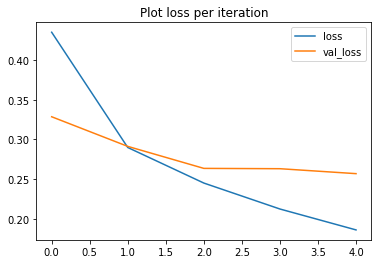

In [12]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

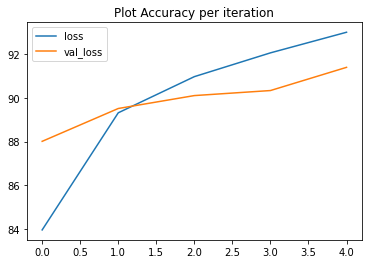

In [13]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()




*   Template Inspired from tensorflow 2.0 [template for expert   
](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb)











